<a href="https://colab.research.google.com/github/brushing-git/Hospital-Readmissions/blob/main/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
from google.colab import drive

# Set random seed
np.random.seed(256)

drive.mount("/content/drive", force_remount=True)
location = 'drive/Shareddrives/273A/balanced_datasets'

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Utility

Utility functions for creating datasets and training models.

In [ ]:
class diabetesDataSet(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]  # get the sample
        features = sample[:len(sample)-1] # get the features, dropping the first item and the target
        target = sample[len(sample)-1] # set the target

        if self.transform:
            sample = self.transform(features)
        if self.target_transform:
            target = self.target_transform(target)

        return features, target

In [ ]:
def train_step(x, t, classifier, opt_fn, loss_fn):
  y = classifier(x.float().cuda())
  loss = loss_fn(y, t.long().cuda())
  loss.backward()
  opt_fn.step()
  opt_fn.zero_grad()
  return loss

In [ ]:
class denseNet(torch.nn.Module):
    def __init__(self, n_dim, layers_param, p=0.0):
        super(denseNet, self).__init__()
        layers = [torch.nn.Linear(n_dim, layers_param[0])]
        for i in range(1, len(layers_param)):
          layers.append(torch.nn.Linear(layers_param[i-1], layers_param[i]))
        self.layers = torch.nn.ModuleList(layers)
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p)

    def forward(self, x):
        y = self.activation(self.layers[0](x))
        for l in self.layers[1:(len(self.layers)-1)]:
          y = self.activation(l(y))
          y = self.dropout(y)
        y = self.layers[len(self.layers)-1](y)
        return y

In [ ]:
def compute_roc(model, tr_set, va_set):
  def convert_to_1Hot(arr):
    arr = arr.astype(int)
    shape = (arr.size, arr.max()+1)
    one_hot = np.zeros(shape)
    rows = np.arange(arr.size)
    one_hot[rows, arr] = 1
    return one_hot
  
  model.cpu()
  model.eval()
  Ytr = []
  YtrHat = []
  Yva = []
  YvaHat = []

  for i in range(len(tr_set)):
    x, y = tr_set[i]
    yhat = model(torch.from_numpy(x).float())
    yhat = yhat.detach().numpy()
    yhat = softmax(yhat)
    Ytr.append(y)
    YtrHat.append(yhat)

  for i in range(len(va_set)):
    x, y = va_set[i]
    yhat = model(torch.from_numpy(x).float())
    yhat = yhat.detach().numpy()
    yhat = softmax(yhat)
    Yva.append(y)
    YvaHat.append(yhat)

  Ytr = np.asarray(Ytr)
  YtrHat = np.asarray(YtrHat)
  Yva = np.asarray(Yva)
  YvaHat = np.asarray(YvaHat)
  auc_tr = roc_auc_score(convert_to_1Hot(Ytr), YtrHat)
  auc_va = roc_auc_score(convert_to_1Hot(Yva), YvaHat)
  return auc_tr, auc_va

# Data

We build up the data.  We split a portion of the data for a true validation set.  The remaining data will be used for cross-validation purposes.  Split is 80/20.

In [ ]:
X = pd.read_csv(os.path.join(location, 'X_train.csv'))
Y = pd.read_csv(os.path.join(location, 'Y_train.csv'))
X['readmitted'] = Y['readmitted']

X = X.to_numpy()
# Shuffle the Data
np.random.shuffle(X)
# Reform the test data
Y = X[:,X.shape[1]-1]
X = X[:,:X.shape[1]-1]
Y = Y.reshape(len(Y), 1)

# Master split of the data
tr_idx = round(len(X)*0.8)
Xtr = X[:tr_idx]
Ytr = Y[:tr_idx]
Xva = X[tr_idx:]
Yva = Y[tr_idx:]

kfold = KFold(n_splits=10)

In [ ]:
n_features = len(X[0,:])

# Model Training

The model training algorithm for doing 10-fold cross-validation.

In [ ]:
def train_model(m_type, n_features, m_params, epochs, dropout=0.0):
  aucs = []  
  for fold, (tr_idx, te_idx) in enumerate(kfold.split(Xtr, Ytr)):
    # Divide the data into folds
    xtr_fold = Xtr[tr_idx]
    xte_fold = Xtr[te_idx]
    ytr_fold = Ytr[tr_idx]
    yte_fold = Ytr[te_idx]

    # Combine and form a torch data set
    tr = np.append(xtr_fold, ytr_fold, 1)
    te = np.append(xte_fold, yte_fold, 1)
    tr_set = diabetesDataSet(tr, transform=torch.from_numpy, target_transform=None)
    va_set = diabetesDataSet(te, transform=torch.from_numpy, target_transform=None)
    tr_loader = torch.utils.data.DataLoader(tr_set, batch_size=100, shuffle=True)
  
    # Train the model
    model = m_type(n_dim=n_features, layers_param=m_params, p=dropout)
    loss = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    print('Training model in fold ' + str(fold))
    for epoch in range(epochs):
      model.train()
      model_c = model.cuda()
      for x,t in iter(tr_loader):
        loss_ = train_step(x, t, model_c, opt, loss)
        y = model_c(x.float().cuda()).cpu()
      print(loss_)

    # Compute the AUC
    tr_auc, va_auc = compute_roc(model, tr_set, va_set)
    aucs.append([tr_auc, va_auc])
  
  # Return the average of the AUCs
  aucs = np.asarray([aucs])
  tr_avg = np.mean(aucs[:,0])
  va_avg = np.mean(aucs[:,1])
  return tr_avg, va_avg

# Hyperparameter Selection 1: Layers and Nodes

Here, we aim to find the optimum set of hyperparameters.  We start by checking for network depth and network width, training 25 models from 1 to 5 hidden layers, and 4 to 100 nodes per layer.  We compute their AUCs on 10-fold cross-validation.

In [ ]:
L = [i for i in range(1,6,1)]
N = [i**2 for i in range(2,12,2)]
networks_params = []

for l in L:
  for n in N:
    params = []
    for _ in range(l):
      params.append(n)
    params.append(2)
    networks_params.append(params)

In [ ]:
aucs = []

for i, p in enumerate(networks_params):
  print("Training model with " + str(p) + " parameters.  Model number " + str(i+1) + " out of " + str(len(networks_params)))
  tr_auc, va_auc = train_model(m_type=denseNet, n_features=n_features, m_params=p, epochs=10)
  aucs.append([tr_auc, va_auc])

Training model with [4, 2] parameters.  Model number 1 out of 25
Training model in fold 0
tensor(0.5282, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7381, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5984, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8488, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6996, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8997, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6369, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6074, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6270, device='cuda:0', grad_fn=<NllLossBackward>)
Training model in fold 1
tensor(0.6658, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5404, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6243, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7678, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)


Seaborn heatmap plots of AUC values.  X-axis if number of nodes.  Y-axis is number of layers.

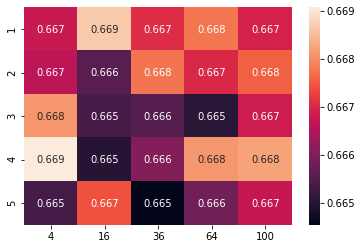

In [ ]:
aucs = np.asarray(aucs)
tr_aucs = aucs[:,0]
va_aucs = aucs[:,1]
tr_aucs = tr_aucs.reshape((5,5))
va_aucs = va_aucs.reshape((5,5))

sns.heatmap(tr_aucs, xticklabels=N, yticklabels=L, annot=True, fmt='.3g')

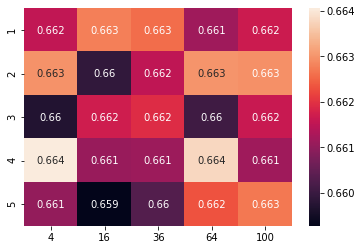

In [ ]:
sns.heatmap(va_aucs, xticklabels=N, yticklabels=L, annot=True, fmt='.3g')

The above maps indicate that the highest performing models were either a network with about 16 nodes distributed among 1 or 4 layers or a deeper network with about 64 nodes per layer for 4 layers.  Training numbers indicate that these wider and deeper networks were more prone to overfitting on the training data.

# Hyperparameter Selection 2: Compression Tests

Next I tested whether an algorithm compressing the data would be good.  What I did was restrict a network to 92 nodes and to find the benefit of varying levels of compression.  Network architectures were [24,24,24,24,2], [36,20,20,20,2], [48,16,16,16,2], [64,12,12,12,2], [76,8,8,8,2].

In [ ]:
inputS_params = [[24,24,24,24,2], [36,20,20,20,2], [48,16,16,16,2], [64,12,12,12,2], [76,8,8,8,2]]
percS = [0.5, 0.75, 1.0, 1.25, 1.5]
inS_aucs = []

for i, p in enumerate(inputS_params):
  print("Training model with " + str(p) + " parameters.  Model number " + str(i+1) + " out of " + str(len(inputS_params)))
  tr_auc, va_auc = train_model(m_type=denseNet, n_features=n_features, m_params=p, epochs=10)
  inS_aucs.append([tr_auc, va_auc])

Training model with [24, 24, 24, 24, 2] parameters.  Model number 1 out of 5
Training model in fold 0
tensor(0.6896, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6358, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6923, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6079, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6795, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8032, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6534, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7744, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6168, device='cuda:0', grad_fn=<NllLossBackward>)
Training model in fold 1
tensor(0.6774, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8333, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6077, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7003, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8711, device='cuda:0', grad_fn=<NllLos

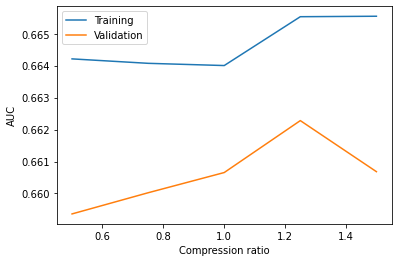

In [ ]:
inS_aucs = np.asarray(inS_aucs)
tr_aucs = inS_aucs[:,0]
va_aucs = inS_aucs[:,1]

plt.figure()
plt.plot(percS, tr_aucs, label='Training')
plt.plot(percS, va_aucs, label='Validation')
plt.xlabel('Compression ratio')
plt.ylabel('AUC')
plt.legend()
plt.show()

The results indicate that if compressions occur, it tends to be best be at less than 1.3.

Next I performed compressions iteratively to see if a 'flat' model was superior to one with varying levels of compression from there.  This time I did 4 layers of 16 nodes each as the baseline for a total of 64 nodes.  The compressions between layers attempted to keep them as close as possible to a 2.0 ratio and the total parameters to that 64 mark.

In [ ]:
c_params = [[16,16,16,16,2], [28,12,12,12,2], [32,16,8,8,2], [32,16,8,4,2]]
n_stages = [i for i in range(4)]
c_aucs = []

for i, p in enumerate(c_params):
  print("Training model with " + str(p) + " parameters.  Model number " + str(i+1) + " out of " + str(len(c_params)))
  tr_auc, va_auc = train_model(m_type=denseNet, n_features=n_features, m_params=p, epochs=10)
  c_aucs.append([tr_auc, va_auc])

Training model with [16, 16, 16, 16, 2] parameters.  Model number 1 out of 4
Training model in fold 0
tensor(0.5917, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7020, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6009, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6363, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8062, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6143, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7615, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7766, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5056, device='cuda:0', grad_fn=<NllLossBackward>)
Training model in fold 1
tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6323, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6314, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7518, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6549, device='cuda:0', grad_fn=<NllLos

In [ ]:
c_aucs = np.asarray(c_aucs)
tr_aucs = c_aucs[:,0]
va_aucs = c_aucs[:,1]

plt.figure()
plt.plot(n_stages, tr_aucs, label='Training')
plt.plot(n_stages, va_aucs, label='Validation')
plt.xlabel('Number of Compression Stages')
plt.ylabel('AUC')
plt.legend()
plt.show()

NameError: ignored

# Hyperparameter Selection:  Regularization

Next, we tested different regularization values for the neural networks.  The type of regularization we used was L2.  Value ranges were tested on the best performing big network with [64,64,64,64,2] nodes and layers.  Values tested were in a range $\alpha = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]$.

In [ ]:
def train_model_Ltwo(m_type, n_features, m_params, alpha, epochs):
  aucs = []  
  for fold, (tr_idx, te_idx) in enumerate(kfold.split(Xtr, Ytr)):
    # Divide the data into folds
    xtr_fold = Xtr[tr_idx]
    xte_fold = Xtr[te_idx]
    ytr_fold = Ytr[tr_idx]
    yte_fold = Ytr[te_idx]

    # Combine and form a torch data set
    tr = np.append(xtr_fold, ytr_fold, 1)
    te = np.append(xte_fold, yte_fold, 1)
    tr_set = diabetesDataSet(tr, transform=torch.from_numpy, target_transform=None)
    va_set = diabetesDataSet(te, transform=torch.from_numpy, target_transform=None)
    tr_loader = torch.utils.data.DataLoader(tr_set, batch_size=100, shuffle=True)
  
    # Train the model
    model = m_type(n_dim=n_features, layers_param=params)
    loss = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=alpha)

    print('Training model in fold ' + str(fold))
    for epoch in range(epochs):
      model.train()
      model_c = model.cuda()
      for x,t in iter(tr_loader):
        loss_ = train_step(x, t, model_c, opt, loss)
        y = model_c(x.float().cuda()).cpu()
      print(loss_)

    # Compute the AUC
    tr_auc, va_auc = compute_roc(model, tr_set, va_set)
    aucs.append([tr_auc, va_auc])
  
  # Return the average of the AUCs
  aucs = np.asarray([aucs])
  tr_avg = np.mean(aucs[:,0])
  va_avg = np.mean(aucs[:,1])
  return tr_avg, va_avg

In [ ]:
A = [0.0, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
params = [64,64,64,64,2]
ltwo_aucs = []

for i, a in enumerate(A):
  print("Training model with " + str(a) + " alpha.  Model number " + str(i+1) + " out of " + str(len(A)))
  tr_auc, va_auc = train_model_Ltwo(m_type=denseNet, n_features=n_features, m_params=params, alpha=a, epochs=10)
  ltwo_aucs.append([tr_auc, va_auc])

Training model with 0.0 alpha.  Model number 1 out of 10
Training model in fold 0
tensor(0.5428, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7490, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5537, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6027, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6118, device='cuda:0', grad_fn=<NllLossBackward>)
Training model in fold 1
tensor(0.7945, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4256, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6864, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0

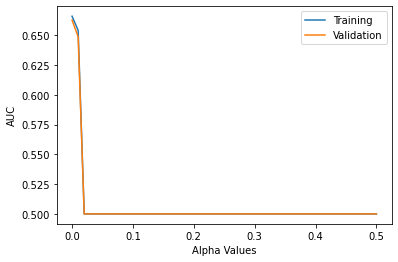

In [ ]:
ltwo_aucs = np.asarray(ltwo_aucs)
tr_aucs = ltwo_aucs[:,0]
va_aucs = ltwo_aucs[:,1]

plt.figure()
plt.plot(A, tr_aucs, label='Training')
plt.plot(A, va_aucs, label='Validation')
plt.xlabel('Alpha Values')
plt.ylabel('AUC')
plt.legend()
plt.show()

The results indicate that L2 regularization is incredibly counterproductive.  Performance nose-dives with any $\alpha > 0$.

# Early Stopping

For early stopping, I evaluated a set large model of [64,64,64,64,2] nodes and layers.  No cross-validation was done.  The epochs trained were up to values of 300 in increments of 10.

In [ ]:
epochs = [i for i in range(10,310,10)]
params = [64,64,64,64,2]
e_aucs = []

tr = np.append(Xtr, Ytr, 1)
va = np.append(Xva, Yva, 1)
tr_set = diabetesDataSet(tr, transform=torch.from_numpy, target_transform=None)
va_set = diabetesDataSet(va, transform=torch.from_numpy, target_transform=None)
tr_loader = torch.utils.data.DataLoader(tr_set, batch_size=100, shuffle=True)

# Set model parameters
params = [64,64,64,64,2]


for i, e in enumerate(epochs):
  print("Training model with " + str(e) + " parameters.  Model number " + str(i+1) + " out of " + str(len(epochs)))
  # Train the model
  model = denseNet(n_dim=n_features, layers_param=params)
  loss = torch.nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters(), lr=1e-3)

  print('Training model.')
  for epoch in range(e):
    model.train()
    model_c = model.cuda()
    for x,t in iter(tr_loader):
      loss_ = train_step(x, t, model_c, opt, loss)
      y = model_c(x.float().cuda()).cpu()
    print(loss_)

  # Compute the AUC
  tr_auc, va_auc = compute_roc(model, tr_set, va_set)
  e_aucs.append([tr_auc, va_auc])

Training model with 10 parameters.  Model number 1 out of 30
Training model.
tensor(0.5902, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6863, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6920, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7641, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6372, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6565, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6273, device='cuda:0', grad_fn=<NllLossBackward>)
Training model with 20 parameters.  Model number 2 out of 30
Training model.
tensor(0.6434, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6539, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6745, devic

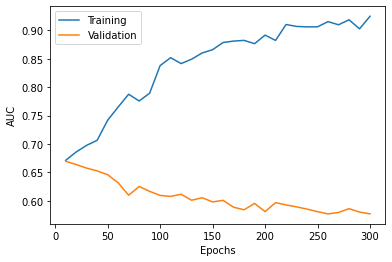

In [ ]:
e_aucs = np.asarray(e_aucs)
tr_aucs = e_aucs[:,0]
va_aucs = e_aucs[:,1]

plt.figure()
plt.plot(epochs, tr_aucs, label='Training')
plt.plot(epochs, va_aucs, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Dropout

Next I applied dropout to see if it improved network performance at all.  The previous results indicate that there is high model variance as the model size increases.  For this test, I tried differing levels of dropout on a model [64,64,64,64,2].

In [ ]:
drop = [i*0.1 for i in range(0,10,1)]
params = [64,64,64,64,2]
d_aucs = []

for i, d in enumerate(drop):
  print("Training model with " + str(d) + " dropout probability.  Model number " + str(i+1) + " out of " + str(len(drop)))
  tr_auc, va_auc = train_model(m_type=denseNet, n_features=n_features, m_params=params, epochs=10, dropout=d)
  d_aucs.append([tr_auc, va_auc])

Training model with 0.0 dropout probability.  Model number 1 out of 10
Training model in fold 0
tensor(0.5449, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6861, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6813, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6015, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6153, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5701, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5716, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6108, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8011, device='cuda:0', grad_fn=<NllLossBackward>)
Training model in fold 1
tensor(0.7069, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7596, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6447, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6216, device='cuda:0', grad_fn=<NllLossBackw

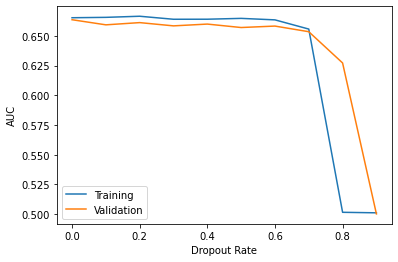

In [ ]:
d_aucs = np.asarray(d_aucs)
tr_aucs = d_aucs[:,0]
va_aucs = d_aucs[:,1]

plt.figure()
plt.plot(drop, tr_aucs, label='Training')
plt.plot(drop, va_aucs, label='Validation')
plt.xlabel('Dropout Rate')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Ideal Model

Next I decided to train an ideal model on the full training set and test it on the hold out validation set.  First we test a few different models around the optimum parameter numbers.  Those models are [4,4,4,4,2], [8,4,4,2], [8,8,2], [16,2].


In [ ]:
te_params = [[4,4,4,4,2], [8,4,4,2], [8,8,2], [16,2]]
model_n = [i+1 for i in range(4)]
te_aucs = []

for i, p in enumerate(te_params):
  print("Training model with " + str(p) + " parameters.  Model number " + str(i+1) + " out of " + str(len(te_params)))
  tr_auc, va_auc = train_model(m_type=denseNet, n_features=n_features, m_params=p, epochs=30)
  te_aucs.append([tr_auc, va_auc])

Training model with [4, 4, 4, 4, 2] parameters.  Model number 1 out of 4
Training model in fold 0
tensor(0.6817, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5687, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6538, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4948, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5775, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7514, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7085, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5636, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8584, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6991, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5734, de

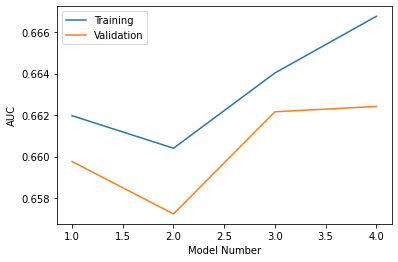

In [ ]:
te_aucs = np.asarray(te_aucs)
tr_aucs = te_aucs[:,0]
va_aucs = te_aucs[:,1]

plt.figure()
plt.plot(model_n, tr_aucs, label='Training')
plt.plot(model_n, va_aucs, label='Validation')
plt.xlabel('Model Number')
plt.ylabel('AUC')
plt.legend()
plt.show()

Next I see if drop out improves model performance at all.

In [ ]:
drop = [i*0.1 for i in range(0,6,1)]
params = [8,8,2]
d_aucs = []

for i, d in enumerate(drop):
  print("Training model with " + str(d) + " dropout probability.  Model number " + str(i+1) + " out of " + str(len(drop)))
  tr_auc, va_auc = train_model(m_type=denseNet, n_features=n_features, m_params=params, epochs=10, dropout=d)
  d_aucs.append([tr_auc, va_auc])

Training model with 0.0 dropout probability.  Model number 1 out of 6
Training model in fold 0
tensor(0.7103, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6282, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6925, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7649, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7755, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5545, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4451, device='cuda:0', grad_fn=<NllLossBackward>)
Training model in fold 1
tensor(0.7562, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5423, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5781, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6171, device='cuda:0', grad_fn=<NllLossBackwa

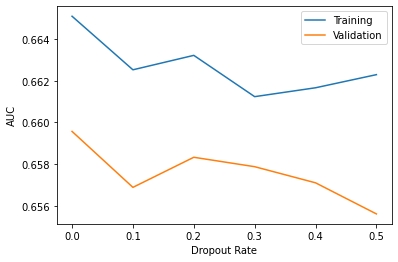

In [ ]:
d_aucs = np.asarray(d_aucs)
tr_aucs = d_aucs[:,0]
va_aucs = d_aucs[:,1]

plt.figure()
plt.plot(drop, tr_aucs, label='Training')
plt.plot(drop, va_aucs, label='Validation')
plt.xlabel('Dropout Rate')
plt.ylabel('AUC')
plt.legend()
plt.show()

The best model is the [8,8,2] model.  Next we train that model for 10 epochs on the full training data set.

In [ ]:
# Build the data set
tr = np.append(Xtr, Ytr, 1)
va = np.append(Xva, Yva, 1)
tr_set = diabetesDataSet(tr, transform=torch.from_numpy, target_transform=None)
va_set = diabetesDataSet(va, transform=torch.from_numpy, target_transform=None)
tr_loader = torch.utils.data.DataLoader(tr_set, batch_size=100, shuffle=True)

# Set model parameters
params = [8,8,2]
# Train the model
model = denseNet(n_dim=n_features, layers_param=params)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

print('Training model.')
for epoch in range(10):
  print('Epoch ' + str(epoch + 1) + ' of ' + str(10))
  model.train()
  model_c = model.cuda()
  for x,t in iter(tr_loader):
    loss_ = train_step(x, t, model_c, opt, loss)
    y = model_c(x.float().cuda()).cpu()
  print(loss_)

# Compute the AUC
tr_auc, va_auc = compute_roc(model, tr_set, va_set)

Training model.
Epoch 1 of 10
tensor(0.6811, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 2 of 10
tensor(0.6293, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 3 of 10
tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 4 of 10
tensor(0.6969, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 5 of 10
tensor(0.6605, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 6 of 10
tensor(0.6910, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 7 of 10
tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 8 of 10
tensor(0.6765, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 9 of 10
tensor(0.7228, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 10 of 10
tensor(0.6067, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
print(tr_auc)
print(va_auc)

0.6628533732904887
0.6669105980035615


# Test Data

I now test the model on the test set.

In [ ]:
X_te = pd.read_csv(os.path.join(location, 'X_test.csv'))
Y_te = pd.read_csv(os.path.join(location, 'Y_test.csv'))
X_te['readmitted'] = Y_te['readmitted']

X_te = X_te.to_numpy()
te_set = diabetesDataSet(X_te, transform=torch.from_numpy, target_transform=None)
te_loader = torch.utils.data.DataLoader(te_set, batch_size=100, shuffle=True)

acc_batch = []
model.cpu()
model.eval()
for x,t in iter(te_loader):
  y = model(x.float())
  acc_batch.append(torch.mean((t == y.argmax(1)).float()))

acc = torch.mean(torch.FloatTensor(acc_batch))
te_auc, va_auc = compute_roc(model, te_set, va_set)
print('Accuracy ' + str(acc))
print('AUC ' + str(te_auc))

Accuracy tensor(0.6084)
AUC 0.6554845126691957
